# 1. Hipotesia
UMDAk suberaketa simulatua baino modularitate hobea ematen du CDP instantzia originalean, 5000 ebaluazio maximorekin.

## Grafoa sortu

In [1]:
!pip install 'scipy>=1.8'
!pip install 'networkx<2.7'

ERROR: Invalid requirement: "'scipy"
El sistema no puede encontrar el archivo especificado.


In [4]:
# SQL
import sqlite3

# Pandas
import pandas as pd

# Graph
import community
import networkx as nx

from pdb import set_trace

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Combinations
import itertools

#Numpy
import numpy as np

#Random
import random



def sortu_grafoa():

    connect = sqlite3.connect('database.sqlite')
    query = """
    SELECT pa.paper_id, pa.author_id, a.name
    FROM paper_authors AS pa JOIN papers AS p ON pa.paper_id = p.id
    JOIN authors as a ON pa.author_id = a.id
    WHERE p.Year BETWEEN '2014' AND '2015'
    """
    df = pd.read_sql(query, connect)
    
    G = nx.Graph()

    for p, a in df.groupby('paper_id')['name']:
      for u, v in itertools.combinations(a, 2):
        if G.has_edge(u, v):
            G[u][v]['weight'] +=1
        else:
          G.add_edge(u, v, weight=1)
    return G

GO = sortu_grafoa()
print(GO.nodes)

['Nan Li', 'Rong Jin', 'Zhi-Hua Zhou', 'Fajwel Fogel', "Alexandre d'Aspremont", 'Milan Vojnovic', 'Nisheeth Srivastava', 'Ed Vul', 'Paul R. Schrater', 'Sewoong Oh', 'Devavrat Shah', 'Siu On Chan', 'Ilias Diakonikolas', 'Rocco A. Servedio', 'Xiaorui Sun', 'Aaron van den Oord', 'Benjamin Schrauwen', 'Robert A. Vandermeulen', 'Clayton Scott', 'Qiang Liu', 'Alexander T. Ihler', 'Joseph G. Makin', 'Philip N. Sabes', 'Isabel Valera', 'Zoubin Ghahramani', 'Kumar Dubey', 'Qirong Ho', 'Sinead A. Williamson', 'Eric P. Xing', 'Anqi Wu', 'Mijung Park', 'Oluwasanmi O. Koyejo', 'Jonathan W. Pillow', 'Balaji Lakshminarayanan', 'Daniel M. Roy', 'Yee Whye Teh', 'Jason Chang', 'John W. Fisher III', 'Mehmet G?nen', 'Adam A. Margolin', 'Qichao Que', 'Mikhail Belkin', 'Yusu Wang', 'Bo Dai', 'Bo Xie', 'Niao He', 'Yingyu Liang', 'Anant Raj', 'Maria-Florina F. Balcan', 'Le Song', 'Krikamol Muandet', 'Bharath Sriperumbudur', 'Bernhard Sch?lkopf', 'Haim Avron', 'Huy Nguyen', 'David Woodruff', 'Wouter M. Koolen'

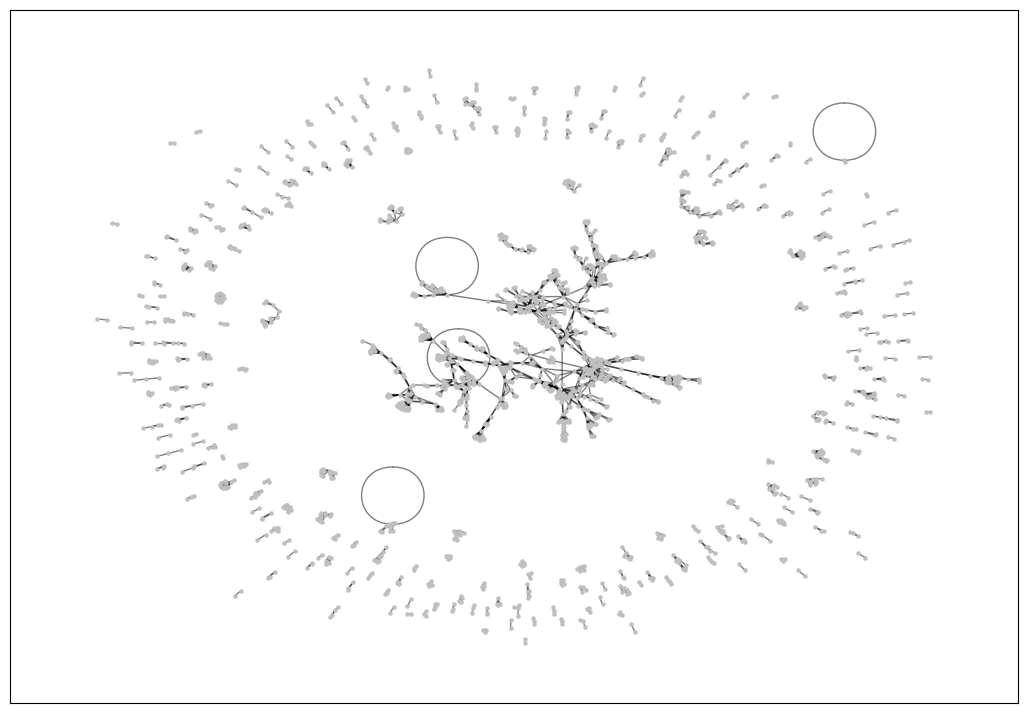

In [5]:
# Grafo originala

#Draw graph
plt.figure(figsize=(13, 9))
pos = nx.spring_layout(GO)
nx.draw_networkx_nodes(GO, pos, node_size = 5, node_color='0.75')
nx.draw_networkx_edges(GO, pos, alpha=0.5, width=1)
plt.show()

# plt.axis('off')
# plt.show()

## Prozesatu grafoa

In [6]:
#Sarrera: G grafo orijinala, k sortu nahi den partizio kopurua
#Irteera: G grafo aurreprozesatua, kodeak hiztegia, pisuakGuztira grafo prozesatuko pisuen batura eta verbose exekuzioari buruzko informazioa duen zerrenda. 
def prozesatu_grafoa(G,k,weight = 'weight'):

    GO = G.copy() #Kopiatu grafo orijinala.

    kodeak = { } #Hasieratu string-zenbaki oso erreferetziak izango dituen hiztegia. 
    pisuakGuztira = 0 #Grafoko ertzen pisuen batura gordeko duen aldagaia hasieratu. 
    
    multzoak = [ ] #Grafoko multzo isolatuak gordeko dituen zerrenda hasieratu.
    aztertuGabeak = list(GO.nodes) #Nodo aztertu gabeen zerrenda hasieran nodo guztiek osatuko dute.
    ilara = [ ]
    verbose = [ ] #Exekuzioari buruzko informazioa biltzeko.
    ##1. FASEA: Grafoko multzo isolatuak topatu eta multzoak zerrendan gorde.
    while (len(aztertuGabeak) > 0): #Multzo guztiak identifikatzeko.
      unekoa = aztertuGabeak[0]  
      ilara.extend(GO.edges(unekoa))
      aztertuGabeak.pop(0)
      multzoa = [unekoa]
      while (len(ilara) > 0): #Zabalerako korritzea erabiltzen da. Multzo baten nodoak identifikatu.
        unekoa = list(ilara.pop(0))[1]
        if (unekoa in aztertuGabeak):
          ilara.extend(GO.edges(unekoa)) #Uneko nodoaren ertzak gehitu ilarara
          aztertuGabeak.remove(unekoa) #Aztertu gabeetatik kendu unekoa.
          multzoa.append(unekoa)
      multzoak.append(multzoa)
    
    #2. FASEA: Zein multzo baztertu erabakitzea.
    listaHandienaTam = len(max(multzoak, key = len)) #Topatu den multzo handienaren nodo kopurua. 
    verbose.append(listaHandienaTam)
    baztergarritasuna = listaHandienaTam/k #Multzo bat baztertua izango da atalase balio hau gainditzen ez badu, hau da, multzo handienaren tamaina zati partizio kopurua.
    verbose.append(baztergarritasuna)
    kendu = [ ]
    maxim=0 
    for i in multzoak: #Atalasea baino txikiagoak diren multzoak baztertzea. Baztertuko diren multzoen nodoak kendu zerrendan bildu. 
      if (len(i) < baztergarritasuna):
        kendu.extend(i)
        if (len(i) > maxim): #Verbose-rentzat, baztertu den multzo handienaren tamaina eskuratzeko.
          maxim=len(i)

    verbose.append(maxim)

    mantenNodo = len(G.nodes) - len(kendu) #Mantenduko den nodo kopurua kalkulatu. 
    kont=0

    #3. FASEA: Baztertzea erabaki den multzoak baztertu.
    for i in kendu:
      GO.remove_node(i) #Multzoaren nodoa ezabatu.
      kodeak[i]=mantenNodo+kont  #Kodeak hiztegian zenbaki oso bat esleitu baztertua izango den nodo honi, baina onartuak izan direnen ondoren. Izan ere, nodo honek ez du edukiko posiziorik soluzio-bektoreetan.
      kont+=1

    #4. FASEA: Onartu diren multzoen nodoei soluzio-bektoreko posizio bat esleitu eta posizio horren zenbaki osoa ipini haien grafoko identifikazio bezala. 
    kont=0
    for i in GO.nodes: #Grafo prozesatuko nodo bakoitzarentzat
      if (i not in kodeak): 
        ertzak=GO.edges(i) #Eskuratu haren ertzak
        for j in ertzak:
          pisuakGuztira+=GO[j[0]][j[1]][weight] #Modularitatean erabiliko den parametroa eguneratu, grafo prozesatuko pisuen batura.
        kodeak[i]=kont #Hiztegian nodoaren identifikazioaren berri eman.
        mapping = {i:kont} #Grafoko nodoen izen aldaketa egiteko.
        kont+=1
        GO = nx.relabel_nodes(GO, mapping) #Grafoko nodoen izen aldaketa egiteko.

    return GO, kodeak, pisuakGuztira, verbose

In [7]:
k=5
G, kodeak, pisuakGuztira, verbose = prozesatu_grafoa(GO,k)
print("GRAFO AURREPROZESATUAREN XEHETASUNAK: ")
print("\nOrijinalaren nodo kopurua: ",len(GO.nodes))
print("Aurreprozesatuaren nodo kopurua: ",len(G.nodes))
print("Multzo handienaren tamaina: ",verbose[0])
print("Bazterketa-tamaina: ",verbose[1])
try:
  print("Baztertu den multzorik handienaren tamaina: ",verbose[2])
except:
  print("Ez da multzorik baztertu.")
print("\n\nKodeak: ",kodeak)
print("Nodo orijinalak: ",GO.nodes)
print("Nodo aurreprozesatuak: ",G.nodes)

GRAFO AURREPROZESATUAREN XEHETASUNAK: 

Orijinalaren nodo kopurua:  1843
Aurreprozesatuaren nodo kopurua:  531
Multzo handienaren tamaina:  531
Bazterketa-tamaina:  106.2
Baztertu den multzorik handienaren tamaina:  67


Kodeak:  {'Nan Li': 531, 'Rong Jin': 532, 'Zhi-Hua Zhou': 533, 'Tianbao Yang': 534, 'Chao Qian': 535, 'Yang Yu': 536, 'Fajwel Fogel': 537, "Alexandre d'Aspremont": 538, 'Milan Vojnovic': 539, 'Dan Alistarh': 540, 'Jennifer Iglesias': 541, 'Nisheeth Srivastava': 542, 'Ed Vul': 543, 'Paul R. Schrater': 544, 'Siu On Chan': 545, 'Ilias Diakonikolas': 546, 'Rocco A. Servedio': 547, 'Xiaorui Sun': 548, 'Moritz Hardt': 549, 'Ludwig Schmidt': 550, 'Eric Price': 551, 'Cynthia Dwork': 552, 'Vitaly Feldman': 553, 'Toni Pitassi': 554, 'Omer Reingold': 555, 'Aaron Roth': 556, 'Alexandr Andoni': 557, 'Piotr Indyk': 558, 'Thijs Laarhoven': 559, 'Ilya Razenshteyn': 560, 'Will Perkins': 561, 'Santosh Vempala': 562, 'Aaron van den Oord': 563, 'Benjamin Schrauwen': 564, 'Robert A. Vander

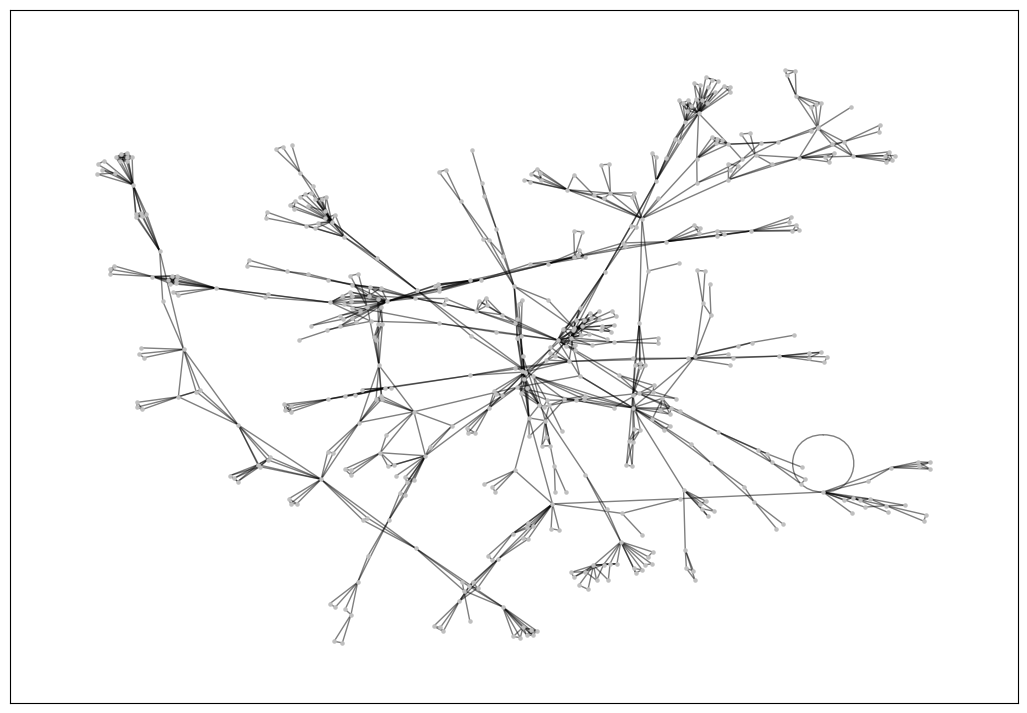

In [8]:
# Grafo originala

#Draw graph
plt.figure(figsize=(13, 9))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size = 5, node_color='0.75')
nx.draw_networkx_edges(G, pos, alpha=0.5, width=1)
plt.show()

# plt.axis('off')
# plt.show()

## Modularitatea

In [9]:
# pip install ipynb exekutatu liburutegi hau erabili ahal izateko.
from itertools import product
import community
import networkx as nx
import numpy as np
import random
import time

#Partizio baten kanpo eta barne pisuak kalkulatzen ditu
def parPisuak (G,soluzioa,k,weight = 'weight'):
  kideak = np.where(soluzioa == k)[0] #K partizioko kideak lortu
  bpisuak = 0
  kpisuak = 0
  for i in range(len(kideak)): #Kide bakoitzerako
    ertzak = G.edges(kideak[i]) #Bere mugakideak eskuratu
    for j in ertzak:
      if (j[1] in kideak): #Mugakidea uneko partizioko kidea bada
        bpisuak+=G[kideak[i]][j[1]][weight] #Barne pisuetara
      else: #Ez bada
        kpisuak+=G[kideak[i]][j[1]][weight] #Kanpo pisuetara
  return(bpisuak/2,kpisuak) #Barne pisuak zati bi egin behar dira, nodo batetik bestera iritsi bada, alderantziz ere egin delako. Kanpo pisuen kasuan ez, kanpoko nodotik barrukorako ertza ez delako aztertu.  

def modularitatea(G, soluzioa, pisuakGuztira):
  time_start = time.time()
  partizioKop=max(soluzioa)+1
  modularitateak = [ ]
  #0 partizioan ahalik eta nodo gutxien egotea nahi dugu, zigortu, beraz, partizio honetan sailkatzea.
  for i in range(1,partizioKop):
    bpisuak, kpisuak = parPisuak(G,soluzioa,i)
    modularitateak.append(bpisuak/pisuakGuztira - ((kpisuak + 2*bpisuak)/(2*pisuakGuztira))**2)
  time_end = time.time()
  # print("Modularitatearen denbora: ", time_end - time_start)
  return sum(modularitateak)

In [10]:
def soluzioa_bideragarria_da (soluzioa,partizio_kopurua,grafoa):
  partizio_kop = max(soluzioa)+1 #Partizio kopurua
  #ZIURTATU: Eskatutako partizio kopurua eta soluzioak dituenak bat datozela. 
  if (partizio_kop != partizio_kopurua):
    #print("SOLBID: Soluzioa ez da bideragarria. Eskatutako partizio kopuruaren desberdina.",partizio_kop,partizio_kopurua)
    return(False)
  partizioen_elem_kop = np.zeros(partizio_kop) #Partizio bakoitzean dagoen autore kopurua
  #ZIURTATU: komunitate bakoitzean gutxienez bi pertsona daude. 
  for j in range(len(soluzioa)): #Soluzio bakoitzerako
    if (soluzioa[j] >= 0): 
      partizioen_elem_kop[soluzioa[j]]+=1 #Batu bat uneko autoreari esleitu zaion partizioan
  if (sum(partizioen_elem_kop < 2) >= 2): #Partizioren batek autore bat edo gutxiago baditu, soluzioa ez da bideragarria. (0 partizioak posible du ez eduki kiderik)
    return(False)
  return(True)

## Simulated Annealing

In [11]:
import math
import random as rm
def eguneratuTenperatura (hasierakoT,oraingoT,iterazioa):
  oraingoT = hasierakoT / (iterazioa+1)
  return(oraingoT)

def gelditu (tenperatura,minimoa,ebal,ebal_kop):
  if (tenperatura < minimoa or ebal >= ebal_kop):
    return(1)
  return(0)

def orekaLortuDa (hobekGabe,atal):
  if (hobekGabe > atal):
    return(1)
  return(0)

def soluzioaOnartuBeharDa (hautagaia,hautagaiaF,onartuaF,tenperatura):
  energia_diferentzia = onartuaF - hautagaiaF
  onarpena = math.exp(-energia_diferentzia/ tenperatura)
  #print(hautagaiaF, onartuaF, onarpena)
  return(onarpena)

In [12]:
#SWAP INGURUNEA
#Swap inguruneak soluzioko edozein digitu beste edozeinekin trukatuta sor
#daitezkeen soluzio guztiak barne hartzen ditu.
def swap_ingurunea(sol,G,k):
  soluzioak = []
  for i in range(len(sol)):
    for j in range(i+1,len(sol)): #i-n dagoen elementua j-n jarri eta j-n dagoena, i-n
      if (sol[i] == sol[j]):
        continue
      nes = sol.copy()
      a = nes[i]
      nes[i] = nes[j]
      nes[j] = a
    if (soluzioa_bideragarria_da(sol,k,G)):
      soluzioak.append(nes)
  return soluzioak

#Bilaketa lokalaren inguruneak eratzeko honako funtzioak erabili daitezke:
#HAMMING INGURUNEA
#Hamming inguruneak uneko soluzioari digitu bat aldatuta sor daitezkeen
#soluzio guztiak barne hartzen ditu.
def hamming_ingurunea(sol,G,k):
  solutions = []
  for i in range(len(sol)): #soluzioko elementu bakoitzerako
    s = sol.copy()
    for j in range(1,k+1):
      s[i] = j
      if soluzioa_bideragarria_da(sol,k,G): #soluzioa bideragarria bada, ingurunean sartu
        solutions.append(s)
  return solutions

def  suberaketaSimulatua (hasierakoBeroa,hoztuDa,atalasea,ebal_kop,G,k,pisuakGuztira):
  kont = 0 #Lehen begiztaren iterazio kontagailua
  ebal = 0
  tenperatura = hasierakoBeroa #Tenperatura gordeko duen aldagaia
  best_solution = np.random.randint(1,k,len(G.nodes)) #Soluzio onena ausazko hasierako soluzio bat da
  best_fitness = modularitatea(G,best_solution,pisuakGuztira) #Helburu funtzioaren bidez ausazko soluzio horren egokitasuna neurtuko dugu
  uneko_sol = best_solution #begizta barruan erabiltzeko aldagaiak
  uneko_fitness = best_fitness #uneko iteraziora arte aurkitu den soluzio onena (bigarren begiztan), ez du zertan inoizko onena izan
  aurrekoIngurunea = swap_ingurunea(best_solution,G,k) #Inguruneak birziklatu eta kalkuluak aurrezteko, beti erabili berri den ingurunea gorde.
  ingurune_onena = aurrekoIngurunea #Ingurune onena gorde, kalkuluak aurrezteko lehen iteraziotik bigarrenera igarotzean.
  while (gelditu(tenperatura,hoztuDa,ebal,ebal_kop) == 0): #Gelditze irizpidea, tenperatura minimora iritsi gara?
    hobekGabe=0 #Bigarren begiztari hasiera eman ahal izateko, hobekGabe behar bezala hasieratu
    aurrekoIngurunea = ingurune_onena #Aurreko ingurunea hasieratu orain arteko soluzio onenaren gordetako ingurunearekin, bigarren begizta ingurune horretan hasiko baita.
    hautagaia= best_solution
    uneko_sol = best_solution
    while (orekaLortuDa(hobekGabe,atalasea) == 0): #Oreka irizpidea, ez da soluzio hoberik aurkitu atalasea iterazioetan?
      hautagaia = random.choice(aurrekoIngurunea)
      hautagaia_fitness = modularitatea(G,hautagaia,pisuakGuztira) #Uneko inguruneko soluziorik onenaren egokitasuna neurtu
      ebal += 1
      #print("Orain arte ebaluazio kopurua:",ebal)
      onartu = soluzioaOnartuBeharDa (hautagaia,hautagaia_fitness,best_fitness,tenperatura) #Soluzioa onargarria den edo ez begiratu
      if (onartu > 1): #Hala bada eta gainera, inoizko onena bada
        best_solution=hautagaia #Soluzio onena bezala hartu
        best_fitness=hautagaia_fitness
        uneko_sol = hautagaia
        uneko_fitness = hautagaia_fitness
        ingurune_onena = swap_ingurunea(best_solution,G,k) #Ingurune berria kalkulatu, zeina ingurune onena ere izango den
        aurreko_ingurunea = ingurune_onena  
        hobekGabe=0 #Hobekuntza bat gertatu da, berrabiarazi oreka-kontagailua, 0 iterazioetan jarraian aurkitu dira unekoa baino soluzio hobeak
        #print("Hobekuntza:",best_fitness)
      elif (rm.random() < onartu): #Soluzioa ez bada inoizko onena, baina onartzea erabaki bada
        uneko_sol = hautagaia
        uneko_fitness = hautagaia_fitness
        hobekGabe+=1 #Ez da hobekuntzarik lortu iterazio honetan, beraz, iterazio bat gehiago jarraian hobekuntzarik lortu gabe
        aurrekoIngurunea = swap_ingurunea(best_solution,G,k) #Hurrengo ingurunea kalkuatu, onartutako soluzioarena, hain zuzen 
        #print("Okertu: ",uneko_fitness, " (",best_fitness,") ")
      else: #Soluzioa ez bada onartu
        hobekGabe+=1 #Hobekuntzarik gabeko beste iterazio bat
        #print("Ukatu: ",hautagaia_fitness, " (",best_fitness,") ")
      #print(hautagaia)  
    kont+=1 #Tenperaturaren eguneraketarako, iterazio bat gehiago igaro da.
    tenperatura= eguneratuTenperatura(hasierakoBeroa,tenperatura,kont) #Tenperatura eguneratu, oreka lortu baita.
    #print("\nOREKA AURKITU DA, tenperatura berria: ",tenperatura,". ",kont," iterazioa")
  return((best_fitness,best_solution))

In [13]:
# best_fitness, best_solution = suberaketaSimulatua (2,0.005,50,5000,G,k,pisuakGuztira)
# print("BUKAERA: ",best_fitness,best_solution)

## UMDA

In [14]:
# Funtzio honek banaketa modelo bat lagintzen du soluzio berri bat sortzeko
# model parametroak soluzioa sortzeko laginduko den modeloa adierazten du (kasu honetan matrize bat)
# size parametroak soluzioaren tamaina adierazten du
def createSolution(model,size):
  sol_berria = [-1]*size # soluzioaren lista hasieratu
  for a,i in enumerate(model):
    p = np.random.uniform(0,1) # ausaz 0 eta 1 tarteko zenbaki bat sortu
    geh = 0 # gehiketa egiten joateko aldagaia
    for ind,j in enumerate(i):
      geh += j # geh aldagaiari orain arteko baloreak gehitu
      if p <= geh: # orain arteko baloreak ausazko zenbakia baino handiagoa edo berdina bada
        sol_berria[a] = ind + 1 # soluzioko a. elementuan tokatu zaion balioa jarri
        break
  return sol_berria # soluzio berria bueltatu

# Funtzio honek bi lista hartzen ditu parametro bezala eta soluzioak lista baloreak listaren arabera ordenatzen du
# soluzioak parametroak ordenatu nahi dugun lista adierazten du
# baloreak parametroak "soluzioak" lista ordenatzeko kontuan eduki behar diren balioak dituen lista adierazten du
def sortByModularity(baloreak,soluzioak):
  return [(sol,mod) for mod, sol in sorted(zip(baloreak, soluzioak))] #soluzioak lista baloreak listaren arabera ordenatu (soluzioak modularitateen arabera ordenatu)

In [15]:
# G parametroa problemaren grafoa da
# pisuakGuztira parametroa grafoko ertz guztien pisuen balioen gehiketa adierazten du
# k parametroa soluzioak zenbat komunitatetan banatuta egotea nahi dugun adierazten du
# max_iter parametroa algoritmoak egin behar dituen iterazioen kopurua adierazten du
# pop_size parametroa populazioaren tamaina adierazten du
def EDA(G,pisuakGuztira,k,max_iter=1000, pop_size=100):
  k = k-1 #komunitate bat gutxi kolaboratu duten autoreentzat erreserbatu dugu, beraz, bakarrik k-1 komunitate esleitu beharko ditugu hemen
  iter = 0 #iterazio kopurua hasieratu
  pop_size = int(pop_size) #populazio tamaina hasieratu
  population = [] 
  populazioaren_modularitateak = []
  avg = [] #batazbesteko modularitateen lista hasieratu
  hoberenak = [] #modularitate hobeen lista hasieratu
  prob_model = len(G)*[[1/k]*k] #hasierako probabilitate modeloa uniformea da. k komunitate daudenez, horietako bakoitza izateko 1/k probabilitatea dago
  for i in range(pop_size): #lehenengo populazioa sortu
      sl = createSolution(prob_model,len(G))
      population.append(sl) #modeloa lagindu eta populazioan sartu
      populazioaren_modularitateak.append(modularitatea(G,np.array(sl),pisuakGuztira))
      iter+=1

  while iter < max_iter: #iterazio maximora ailegatu ez den bitartean
#     print(f'{iter}/{max_iter}') #oraingo iterazioa idatzi

    nppop = np.array(population)
    s = len(nppop)
    for i,column in enumerate(nppop.T): #aldi berean populazioko soluzio guztiak elementuz-elementu zeharkatu
      vec = [0]*k
      for element in column: #komunitate bakoitza zenbat aldiz agertzen den kontatu
        vec[element-1] += 1/s #bektore honetan zenbatuko da komunitate bakoitza i. nodoari zenbat aldiz esleitu zaion populazioko soluzioetan
      prob_model[i] = vec #kalkulatutako modelo berria normalizatu eta probabilitate modeloa eguneratu

    soluzio_berriak = []
    berrien_modularitateak = []
    for i in range(int(pop_size/2)): #pop_size/2 soluzio berri sortu
      sol = createSolution(prob_model,len(G)) #soluzio bat sortu
      soluzio_berriak.append(sol) #soluzio berrietan gorde
      berrien_modularitateak.append(modularitatea(G,np.array(sol),pisuakGuztira))
      iter+=1
      if iter > max_iter: #iterazio kopurua pasatu bada, amaitu
        break
    if iter > max_iter: #iterazio kopurua pasatu bada, amaitu
      break

    extended_population = population.copy()
    extended_population.extend(soluzio_berriak) #soluzio berriak eta populazioa konbinatu
    
    pop_berrirako = populazioaren_modularitateak.copy()
    pop_berrirako.extend(berrien_modularitateak) #populazioaren modularitateak eta soluzio berrien modularitateak konbinatu

    population, populazioaren_modularitateak = zip(*sortByModularity(pop_berrirako,extended_population)[int(pop_size/2):]) #soluzio berrien eta populazioaren konbinaketaren arteko pop_size soluzio hoberenak populaziora pasatu 
    population = list(population) #populazioa tuplatik listara pasatu
    populazioaren_modularitateak = list(populazioaren_modularitateak) #populazioaren modularitateak tuplatik listara pasatu
    
    ## Beheko kodea ez da beharrezkoa algoritmoaren ibilbidea irudikatu nahi ez bada
#     hoberena = []
#     fit_hoberena = float("-inf")
#     av = 0
#     for i in population: #iterazio bakoitzean soluzio hoberenaren modularitatea eta batazbesteko modularitatea kalkulatu grafikoa egiteko
#       m = modularitatea(G,np.array(i),pisuakGuztira)
#       av += m
#       if m > fit_hoberena: #oraingo soluzioa orain arteko maximoa baino moduluaritate handiagoa badu, maximoa oraingoa da
#         fit_hoberena = m
#         hoberena = i
#     hoberenak.append(fit_hoberena) #modularitate hobeen lista
#     avg.append(av/len(population)) #populazioko batazbesteko modularitatearen lista
  hoberena = populazioaren_modularitateak[-1]
  return hoberena#, hoberenak, avg

In [16]:
# iterazioak = 5000
# pop_tam = 85
# best_solution= EDA(G,pisuakGuztira,k,iterazioak,pop_tam) #150000,600 -> 0.4-ko modularitatea, 1.89 ordu
# print(best_solution)
# print(modularitatea(G,np.array(best_solution),pisuakGuztira))

## Hipotesia
UMDA, suberaketa simulatua baino modularitate hobea ematen du CDP instantzia originalean, 5000 ebaluazio maximorekin.

In [17]:
###### Hiperparametroak
iterazioak = 5000
# UMDA
pop_tam = 85
# Simulated Annealing
hasierako_temp = 1
atalasea = 10

###### Exekuzioak
# UMDA
UMDA_best_fitness = EDA(G,pisuakGuztira,k,iterazioak,pop_tam)
# UMDA_best_fitness = modularitatea(G,np.array(UMDA_best_solution),pisuakGuztira)
# Simulated Annealing
SA_best_fitness, SA_best_solution = suberaketaSimulatua(hasierako_temp,0,atalasea,iterazioak,G,k,pisuakGuztira)

print("Simulated Annealing soluziorik hoberena: ", SA_best_fitness)
print("UMDA soluziorik hoberena: ", UMDA_best_fitness)

Simulated Annealing soluziorik hoberena:  0.24525373700770237
UMDA soluziorik hoberena:  0.2521226385645969


In [ ]:
import csv

###### Hiperparametroak
iterazioak = 5000
# UMDA
pop_tam = 85
# Simulated Annealing
hasierako_temp = 1
atalasea = 10

with open('hipotesia1_2.csv','w') as file:
    writer = csv.writer(file)
    writer.writerow(["Simulated Annealing", "UMDA"])    
    SA_sol = []
    UMDA_sol = []
    for i in range(20):
        SA_best_fitness, SA_best_solution = suberaketaSimulatua(hasierako_temp,0,atalasea,iterazioak,G,k,pisuakGuztira)
        SA_sol.append(SA_best_fitness)

        UMDA_best_fitness= EDA(G,pisuakGuztira,k,iterazioak,pop_tam)
        UMDA_sol.append(UMDA_best_fitness)
    writer.writerow(SA_sol)
    writer.writerow(UMDA_sol)